In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [ ]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

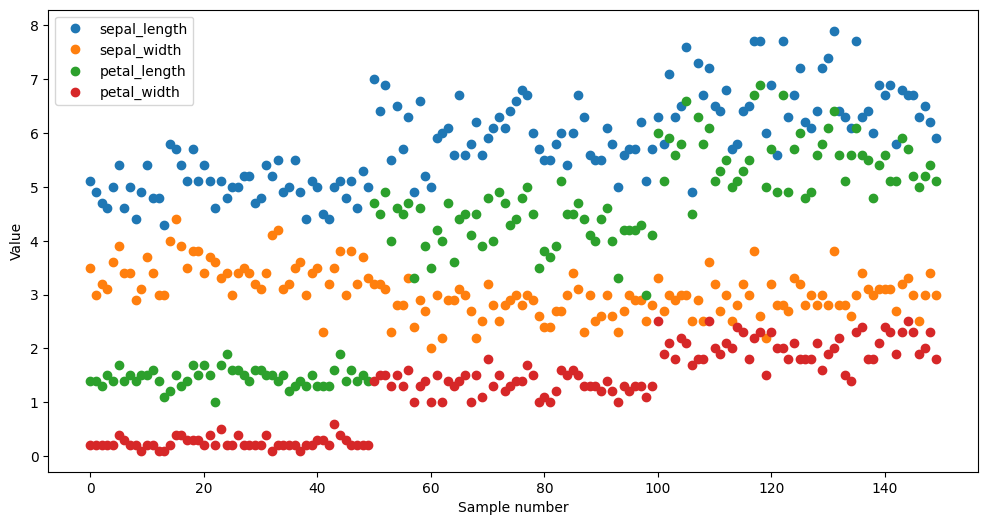

In [ ]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [ ]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [ ]:
# use scikitlearn to split the data
def prepare_data(batch_size:int=16 ,test_size=.2):
    train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=test_size)


    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)


    # finally, translate into dataloader objects
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

    return train_loader, test_loader

In [ ]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel(batch_size:int, ANNiris, lossfun, optimizer):
  train_loader, test_loader = prepare_data(batch_size=batch_size)
  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


In [ ]:
ANNiris, lossfun, optimizer = createANewModel()


In [ ]:
batch_sizes = np.power(2, np.arange(1, 7)).astype(int)

trainAccPerBatches = np.zeros((numepochs, len(batch_sizes)))
testAccaccPerBatches = np.zeros((numepochs, len(batch_sizes)))
lossPerBatches = np.zeros((numepochs, len(batch_sizes)))

for i, bs in enumerate(batch_sizes):
    trainAcc, testAcc, losses = trainTheModel(batch_size=int(bs), ANNiris=ANNiris, lossfun=lossfun, optimizer=optimizer)

    trainAccPerBatches[:, i] = trainAcc
    testAccaccPerBatches[:, i] = testAcc
    lossPerBatches[:, i] = losses

In [ ]:
def smooth(x, k=6):
    return np.convolve(x, np.ones(k) / k, mode="same")

In [ ]:
trainAccPerBatches.shape

(2500, 6)

In [ ]:
testAccaccPerBatches.shape

(2500, 6)

In [ ]:
lossPerBatches.shape

(2500, 6)

In [ ]:
trainAccPerBatches_s = np.zeros(trainAccPerBatches.shape)
testAccaccPerBatches_s = np.zeros(testAccaccPerBatches.shape)
lossPerBatches_s = np.zeros(lossPerBatches.shape)

for i in range(numepochs):
    trainAccPerBatches_s[i, :] = smooth(trainAccPerBatches[i, :], k=6)
    testAccaccPerBatches_s[i, :] = smooth(testAccaccPerBatches[i, :], k=6)
    lossPerBatches_s[i, :] = smooth(lossPerBatches[i, :], k=6)

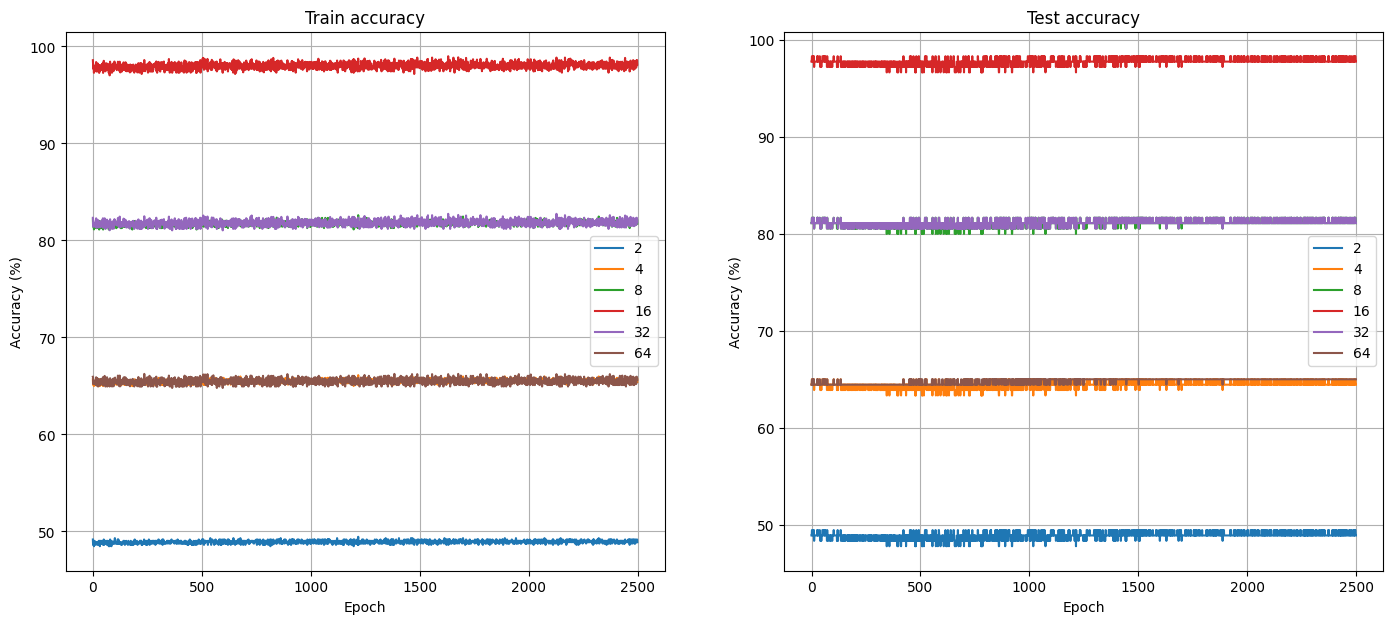

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainAccPerBatches_s)
ax[0].set_title('Train accuracy')
ax[1].plot(testAccaccPerBatches_s)
ax[1].set_title('Test accuracy')

# make the legend easier to read

# common features
for i in range(2):
  ax[i].legend(batch_sizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].grid()

plt.show()

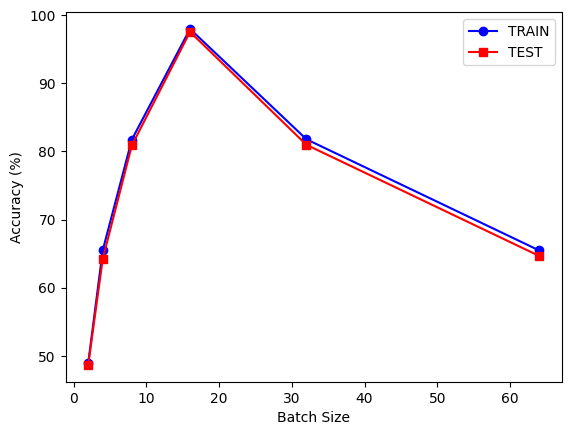

In [ ]:
with torch.no_grad():
    # average only some epochs
    epoch_range = [500,950]


    plt.plot(batch_sizes,
            np.mean(trainAccPerBatches_s[epoch_range[0]:epoch_range[1],:],axis=0),
            'bo-',label='TRAIN')

    plt.plot(batch_sizes,
            np.mean(testAccaccPerBatches_s[epoch_range[0]:epoch_range[1],:],axis=0),
            'rs-',label='TEST')

    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()